In [3]:
import torch as tc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from scipy.stats import norm, multivariate_normal
sys.path.append(r'../') #path to folder where file that stored the results is located

plt.rc('font', family='serif', size=14)
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

In [4]:
run = "./run_2022-12-03_12-53-09/"

In [5]:
with open(run + "graphical_model.pkl", "rb") as f:
    model = pickle.load(f)

proposal_samples = tc.load(run + "proposal_samples.pt").detach().clone().numpy() #latent topological order
proposal_weights = tc.load(run + "proposal_weights.pt").detach().clone().numpy()
proposal_weights = np.abs(proposal_weights)
proposal_weights /= proposal_weights.sum()
idx = np.random.choice(np.arange(len(proposal_weights)), size=len(proposal_weights), p=proposal_weights)
idx = np.random.choice(np.arange(len(proposal_weights)), size=len(proposal_weights))
resamples = proposal_samples[idx]
df1 = pd.DataFrame(proposal_samples, columns = ["slope", "bias"])
df2 = pd.DataFrame(resamples, columns = ["slope", "bias"])
samples_dict = {"proposal" : {"slope" : df1["slope"].to_numpy(), "bias" : df1["bias"].to_numpy()},
                "posterior" :{"slope" : df2["slope"].to_numpy(), "bias" : df2["bias"].to_numpy()}}



In [6]:
# Make a triangle plot to see slope and bias distributions and correlations
def triangle_plot(samples_dict, mu=None, cov=None, **kwargs):
    plt.subplots(2, 2, **kwargs)
    plt.subplot(2, 2, 1)
    for name, samples in samples_dict.items():
        plt.hist(samples['bias'], alpha=0.7, density=True, bins='auto', label=name)
    if mu is not None and cov is not None:
        x, f = get_distribution(plt, mu[0], np.sqrt(cov[0, 0]))
        plt.plot(x, f, color='black', label='analytical')
    plt.gca().set_xticklabels([])
    plt.yticks([])
    plt.legend(prop={'size': 12})
    plt.subplot(2, 2, 4)
    for name, samples in samples_dict.items():
        plt.hist(samples['slope'], alpha=0.7, density=True, bins='auto', label=name)
    if mu is not None and cov is not None:
        x, f = get_distribution(plt, mu[1], np.sqrt(cov[1, 1]))
        plt.plot(x, f, color='black', label='analytical')
    plt.xlabel('slope')
    plt.yticks([])
    plt.subplot(2, 2, 3)
    for name, samples in samples_dict.items():
        plt.scatter(samples['bias'], samples['slope'], alpha=0.5, s=5., label=name)
    if mu is not None and cov is not None:
        X, Y, Z = get_contours(plt, mu, cov)
        plt.contour(X, Y, Z, colors='black', alpha=0.9, levels=3)
    plt.xlabel('bias')
    plt.ylabel('slope')
    plt.subplot(2, 2, 2).axis('off')
    plt.tight_layout()
    plt.show()

# Plot the learning curves to see how training is progressing
def plot_learning_curve(training_logfile, **kwargs):
    data = np.loadtxt(training_logfile, skiprows=1, delimiter=',', converters={8: lambda _: 0.})
    plt.figure(**kwargs)
    plt.plot(data[:, 1], data[:, 3], label='training')
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Analytical expression for the posterior covariance
def analytical_covariance(x, sigma, alpha):
    cov1 = np.identity(2)*(sigma/alpha)**2
    x0_sum = len(x)
    x1_sum = np.sum(x)
    x2_sum = np.sum(x**2)
    cov2 = np.array([
        [x0_sum, x1_sum],
        [x1_sum, x2_sum],
    ])
    cov = (1./sigma**2)*(cov1+cov2)
    cov = np.linalg.inv(cov)
    return cov

# Analytical expression for the posterior mean
def analytical_mean(x, y, sigma, alpha):
    xy_sum = np.sum(x*y)
    y_sum = np.sum(y)
    vec = np.array([y_sum, xy_sum])
    cov = analytical_covariance(x, sigma, alpha)
    mu = np.matmul(cov, vec)/sigma**2
    return mu

# Distribution for 1D marginal posteriors
def get_distribution(plt, mu, sig, N=200):
    xlim = plt.gca().get_xlim()
    x = np.linspace(xlim[0], xlim[1], N)
    rv = norm(mu, sig)
    f = rv.pdf(x)
    return x, f

# Contours for 2D posterior distributions
def get_contours(plt, mu, cov, N=200):
    xlim = plt.gca().get_xlim(); ylim = plt.gca().get_ylim()
    X = np.linspace(xlim[0], xlim[1], N)
    Y = np.linspace(ylim[0], ylim[1], N)
    X, Y = np.meshgrid(X, Y); pos = np.dstack((X, Y))
    rv = multivariate_normal(mu, cov)
    Z = rv.pdf(pos)
    return X, Y, Z


In [7]:
observed = []
for var in model.topological():
    if var in model.Graph["Y"].keys():
        observed.append(tc.tensor(model.Graph["Y"][var]).float())


x = np.array([1., 2., 3., 4., 5., 6.])
sigma = 1.0  # Likelihood error
alpha = 10.0 # Prior scale
observed = tc.stack(observed).numpy()
mu = analytical_mean(np.array(x), np.sort(observed), sigma, alpha)
cov = analytical_covariance(np.array(x), sigma, alpha)
print(mu)
print(cov)

[-0.50466187  2.14919125]
[[ 0.85882716 -0.19816911]
 [-0.19816911  0.05671411]]


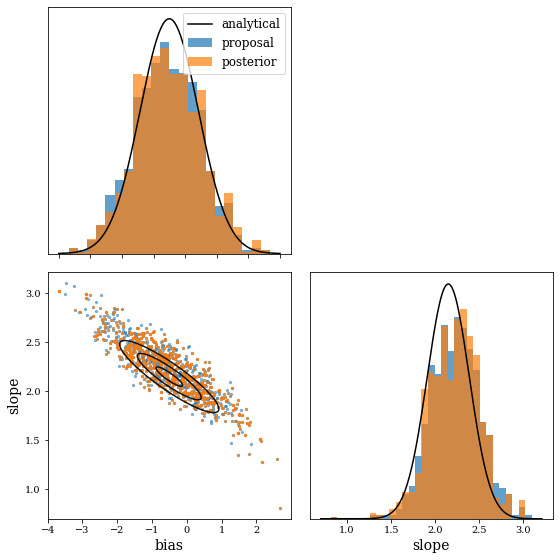

In [8]:
triangle_plot(samples_dict, mu, cov, figsize=(8,8))


In [13]:
observed = []
for var in model.topological():
    if var in model.Graph["Y"].keys():
        observed.append(tc.tensor(model.Graph["Y"][var]).float())

observed = tc.stack(observed)

observed_test1 = np.random.normal(1 * x + 3, scale = sigma)
observed_test1 = tc.tensor(observed_test1[observed.argsort().argsort()]).float()

observed_test2 = np.random.normal(5 * x + 8, scale = sigma)
observed_test2 = tc.tensor(observed_test2[observed.argsort().argsort()]).float()

observed_test3 = np.random.normal(9 * x + 13, scale = sigma)
observed_test3 = tc.tensor(observed_test3[observed.argsort().argsort()]).float()

In [10]:
def plot_proposal_by_epochs(epochs : int, observed : tc.Tensor, model, num_samples = 2000, **kwargs):
    
    latents = [var for var in model.topological() if var.startswith("sample")]
    fig, axs = plt.subplots(2, epochs, **kwargs)

    x = np.array([1., 2., 3., 4., 5., 6.])
    mu = analytical_mean(np.array(x), np.sort(observed), sigma, alpha)
    cov = analytical_covariance(np.array(x), sigma, alpha)

    for i, latent in enumerate(latents):
        for epoch in range(epochs):
            with open(run + "proposal_epoch{}.pkl".format(epoch), "rb") as f:
                proposal = pickle.load(f)
            
            proposal_samples = []
            for _ in range(num_samples):
                sample = proposal.sample(y = observed)[latent]
                proposal_samples.append(sample)

            proposal_samples = tc.stack(proposal_samples).numpy()
            axs[i,epoch].hist(proposal_samples, bins="auto", label="Epoch {}".format(epoch + 1), density=True)
            xlim = axs[i,epoch].get_xlim()
            x = np.linspace(xlim[0], xlim[1], 5000)
            rv = norm(mu[1-i], np.sqrt(cov[1-i,1-i]))
            f = rv.pdf(x)
            
            axs[i,epoch].plot(x, f, label="Analytical posterior")

            axs[i,epoch].legend(loc="upper right", prop = {"size" : 12})
    
    axs[0,0].set_ylabel("slope")
    axs[1,0].set_ylabel("bias")

torch.return_types.sort(
values=tensor([ 2.1000,  3.9000,  5.3000,  7.7000, 10.2000, 12.9000]),
indices=tensor([5, 3, 0, 4, 2, 1]))


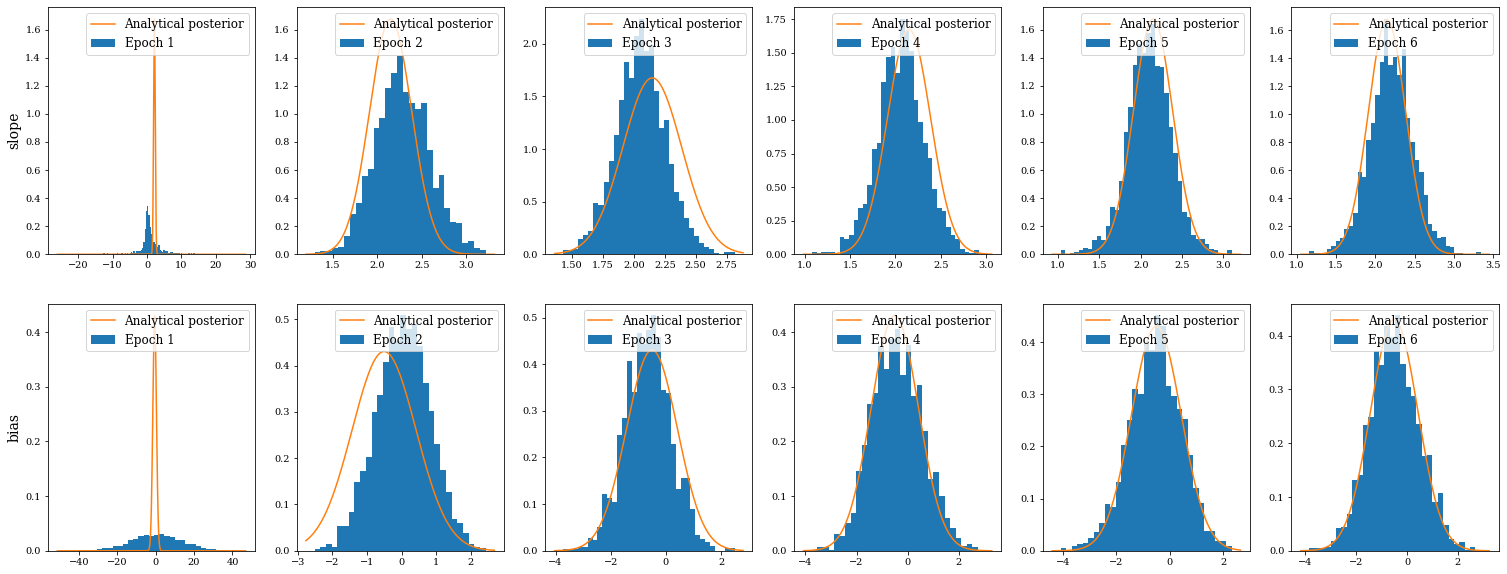

In [17]:
plot_proposal_by_epochs(epochs=6, observed=observed, model=model, figsize=(26,10))
print(observed.sort())

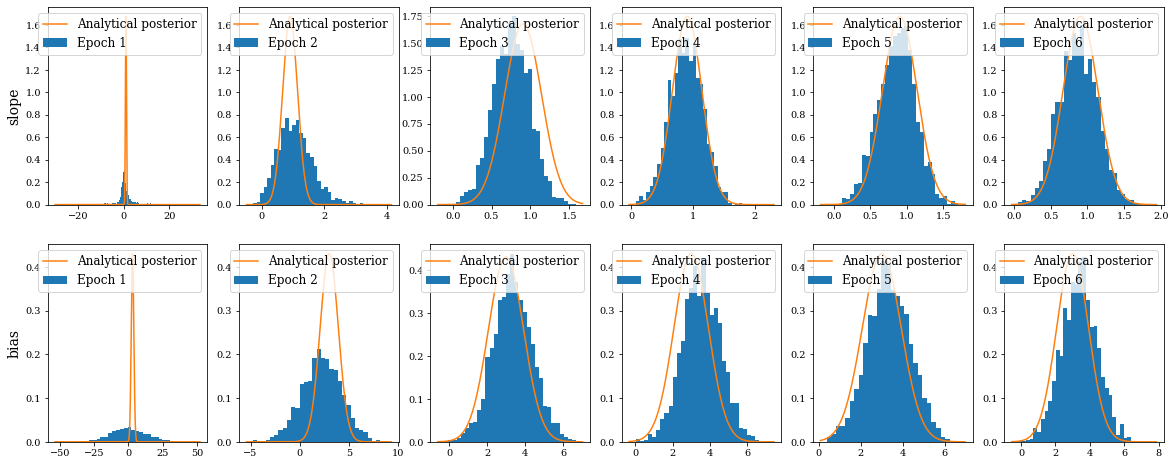

In [14]:
plot_proposal_by_epochs(epochs=6, observed=observed_test1, model=model, figsize=(20,8))
print(observed_test1.sort())

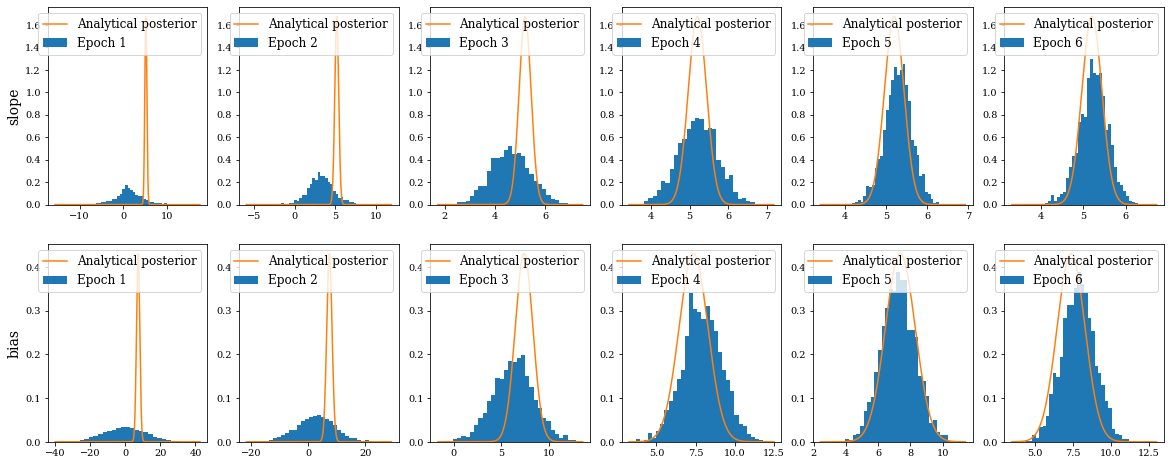

In [15]:
plot_proposal_by_epochs(epochs=6, observed=observed_test2, model=model, figsize=(20,8))

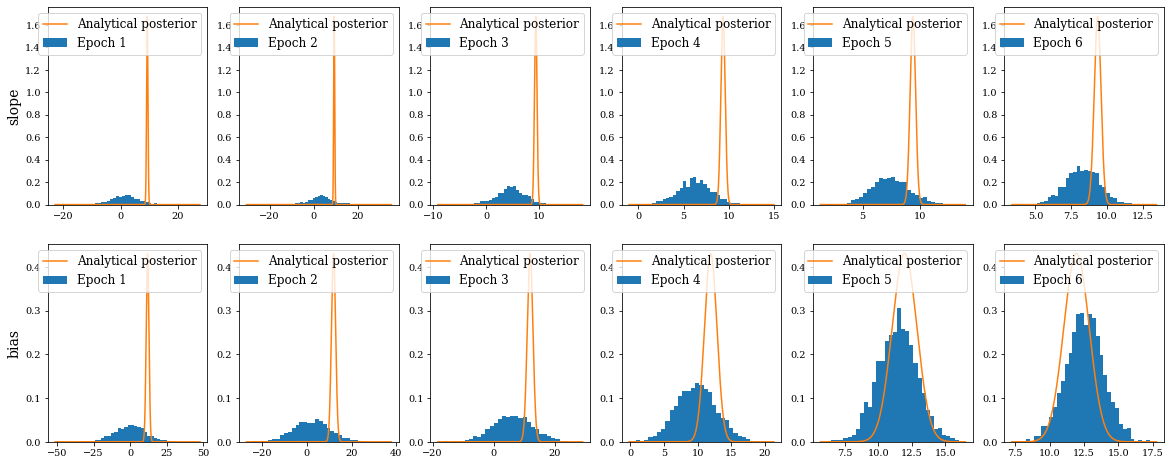

In [16]:
plot_proposal_by_epochs(epochs=6, observed=observed_test3, model=model, figsize=(20,8))

In [36]:
def plot_losses(**kwargs):
    losses = tc.load(run + "losses.pt")
    fig, axs = plt.subplots(1, len(losses), **kwargs)
    for i, loss in enumerate(losses):
        axs[i].plot(loss, label="epoch {}".format(i))
        axs[i].legend()
    return


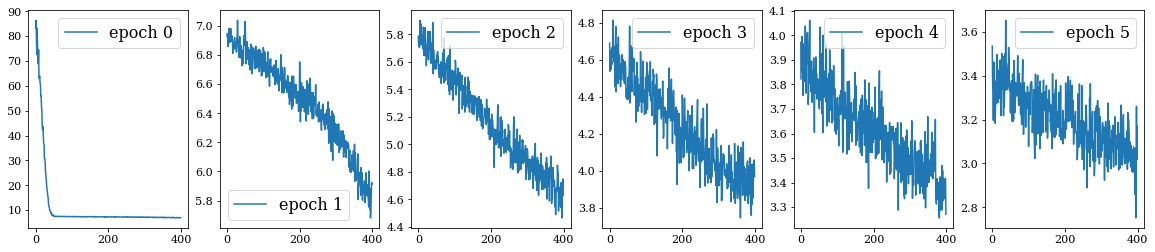

In [37]:
plot_losses(figsize=(20,4))